In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [87]:
!wget https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx

--2023-04-06 12:22:17--  https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-04-06 12:22:17 ERROR 403: Forbidden.



In [88]:
df = pd.read_excel('us_macro_quarterly.xlsx')

df.head()

/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [89]:
def parse_date(data):
    # quarter is in {01, 02, 03, 04}
    year, quarter = data.split(':')
    month = (int(quarter) - 1) * 3 + 1
    s = f"{year}-{month}"
    return datetime.strptime(s, "%Y-%m")

In [90]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)

In [91]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


In [92]:
df.set_index(df['Date'], inplace=True)
df.drop(['Date', 'Unnamed: 0'], axis=1, inplace=True)


In [93]:
df.index.freq = 'QS'

In [94]:
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


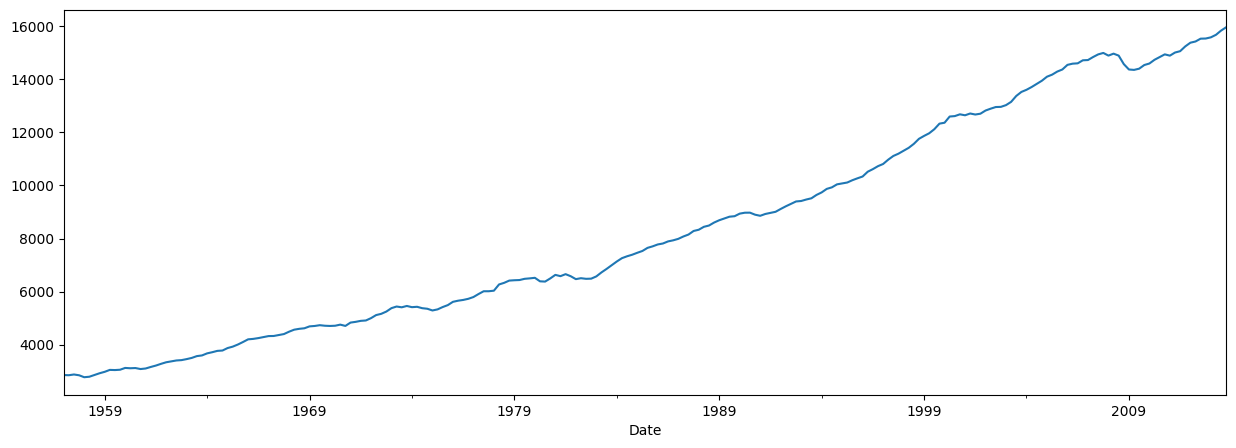

In [95]:
#GDP
df['GDPC96'].plot(figsize=(15, 5));

In [96]:
df['GDPGrowth'] = np.log(df['GDPC96']).diff()

In [97]:
df['TSpread'] = df['GS10'] - df['TB3MS']

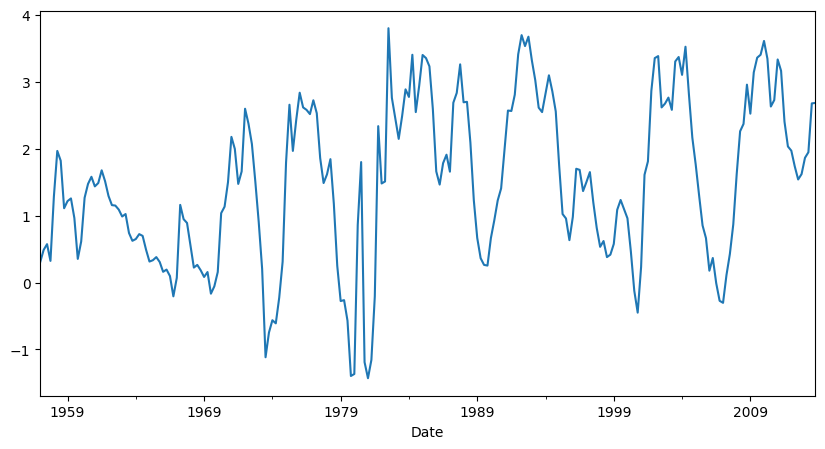

In [98]:
df['TSpread'].plot(figsize=(10, 5));

In [99]:
cols = ['GDPGrowth', 'TSpread']

In [100]:
df1 = df.iloc[1:][cols].copy()

In [101]:
Ntest = 12
train = df1.iloc[:-Ntest].copy()
test = df1.iloc[-Ntest:].copy()

In [102]:
train_idx = df1.index <= train.index[-1]
test_idx = ~train_idx

In [103]:
scaler = StandardScaler()
# overwrite originals, unless you want to preseve them
train[cols] = scaler.fit_transform(train)
test[cols] = scaler.transform(test)


In [104]:
df1.loc[train_idx, :] = train
df1.loc[test_idx, :] = test

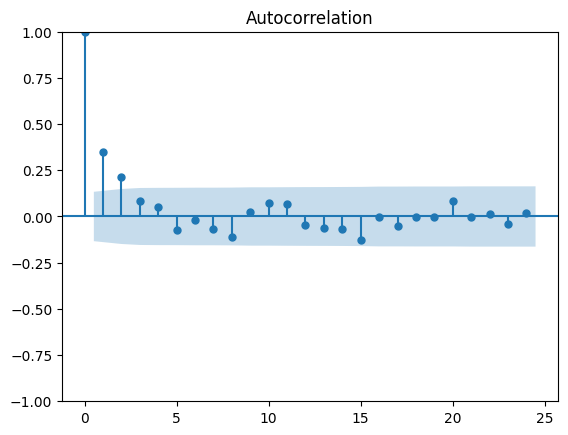

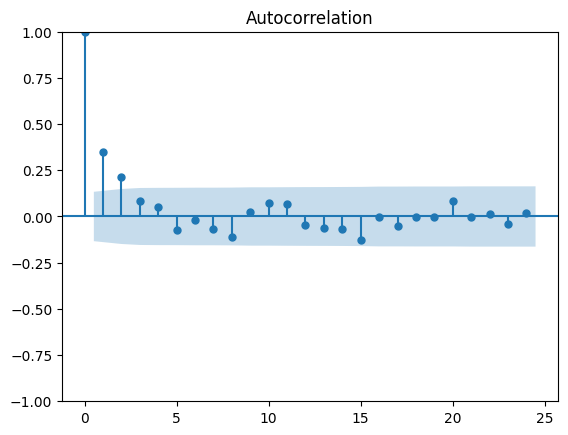

In [105]:
plot_acf(train['GDPGrowth'])

/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


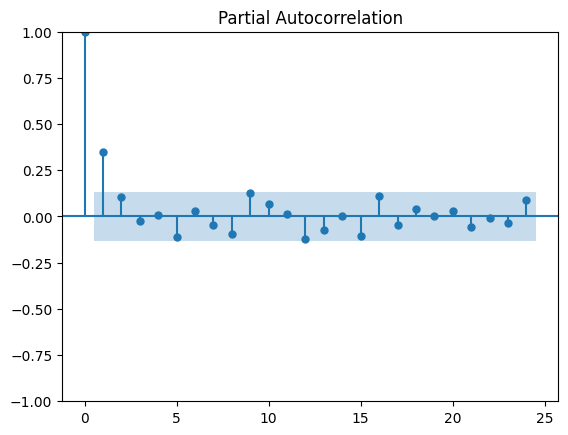

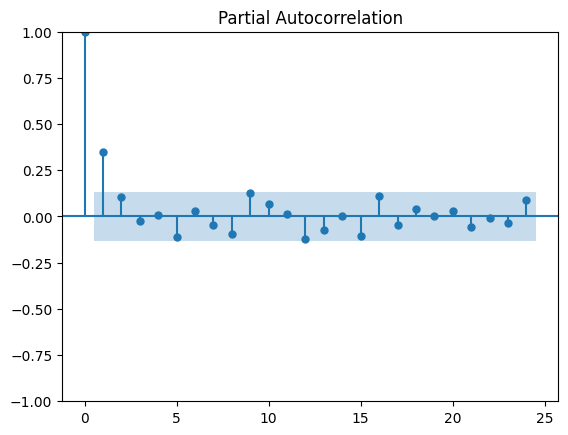

In [106]:
plot_pacf(train['GDPGrowth'])

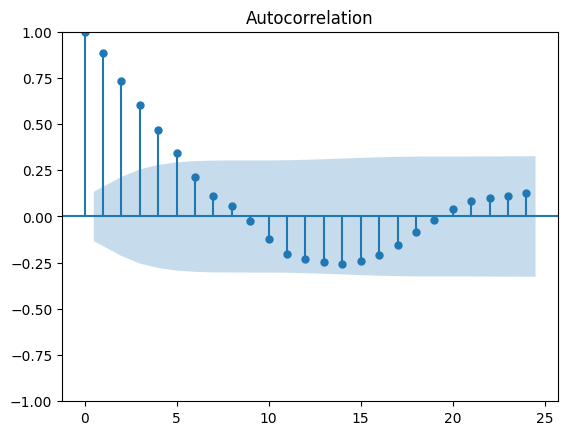

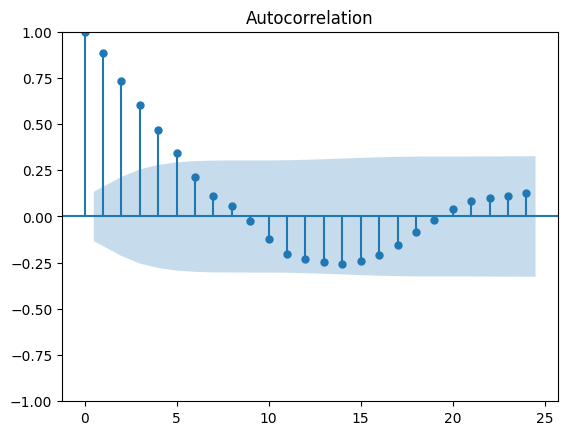

In [107]:
plot_acf(train['TSpread'])

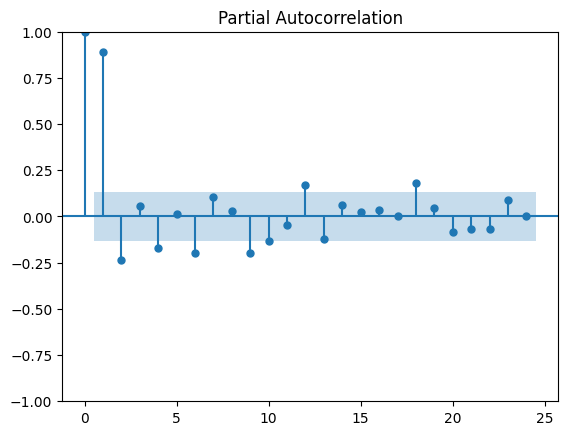

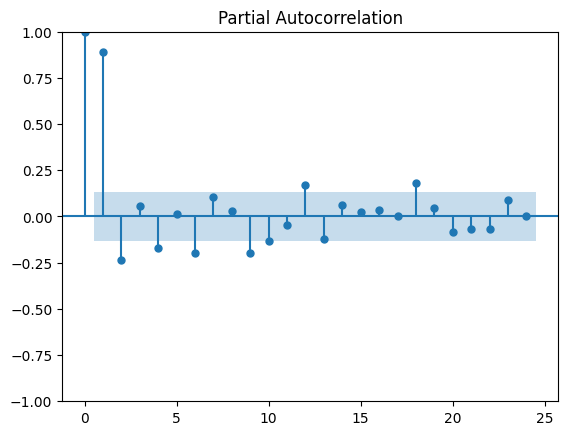

In [108]:
plot_pacf(train['TSpread'])

In [109]:
adfuller(train['GDPGrowth'])

(-7.446639654625591,
 5.8148965809135303e-11,
 1,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 512.8542310637395)

In [110]:
adfuller(train['TSpread'])

(-4.001020795475584,
 0.001405175490749345,
 12,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 246.36949884218734)

In [111]:
p = 18
q = 1

In [112]:
t0 = datetime.now()
model = VARMAX(train, order=(p, q))
res = model.fit(maxtier=100)
print(f"Duration: {datetime.now() - t0}")

/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: maxtier. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           81     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64746D+00    |proj g|=  5.79231D-01


 This problem is unconstrained.



At iterate    5    f=  1.62085D+00    |proj g|=  1.77252D-01

At iterate   10    f=  1.61868D+00    |proj g|=  1.83062D-02

At iterate   15    f=  1.61823D+00    |proj g|=  2.51773D-02

At iterate   20    f=  1.61785D+00    |proj g|=  7.64954D-03

At iterate   25    f=  1.61741D+00    |proj g|=  6.85301D-03

At iterate   30    f=  1.61648D+00    |proj g|=  1.02741D-02

At iterate   35    f=  1.61530D+00    |proj g|=  6.18290D-02

At iterate   40    f=  1.61462D+00    |proj g|=  3.21932D-02

At iterate   45    f=  1.61436D+00    |proj g|=  5.17821D-03


/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.61428D+00    |proj g|=  4.14009D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   81     50     60      1     0     0   4.140D-03   1.614D+00
  F =   1.6142836380633268     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Duration: 0:01:01.993531


In [113]:
fcast = res.get_forecast(Ntest)

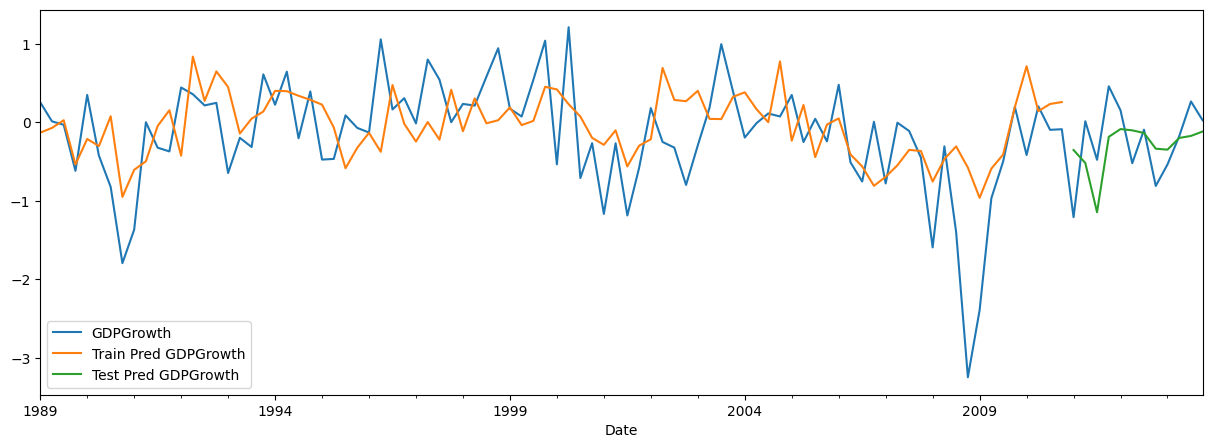

In [114]:
df1.loc[train_idx, 'Train Pred GDPGrowth'] = res.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test Pred GDPGrowth'] = fcast.predicted_mean['GDPGrowth']
plot_cols = ['GDPGrowth', 'Train Pred GDPGrowth', 'Test Pred GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15, 5));

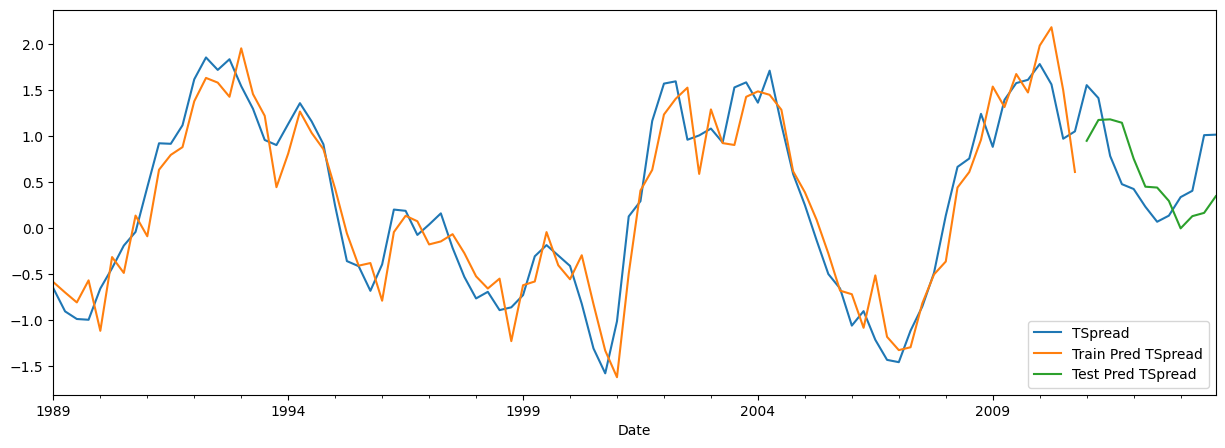

In [115]:
df1.loc[train_idx, 'Train Pred TSpread'] = res.fittedvalues['TSpread']
df1.loc[test_idx, 'Test Pred TSpread'] = fcast.predicted_mean['TSpread']
plot_cols = ['TSpread', 'Train Pred TSpread', 'Test Pred TSpread']
df1.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [116]:
for col in cols:
    y_true = df1.loc[train_idx, col]
    y_pred = res.fittedvalues[col]
    print(f"Train R^2: {r2_score(y_true, y_pred)}")

    y_true = df1.loc[test_idx, col]
    y_pred = fcast.predicted_mean[col]
    print(f"Test R^2: {r2_score(y_true, y_pred)}")

Train R^2: 0.27730008451736676
Test R^2: -0.01466240767001814
Train R^2: 0.8734109469375215
Test R^2: -0.0014160283554873754


VAR

In [117]:
model = VAR(train)

In [118]:
lag_order_results = model.select_order(maxlags=20)
lag_order_results.selected_orders

{'aic': 10, 'bic': 1, 'hqic': 2, 'fpe': 10}

In [119]:
results = model.fit(maxlags=20, ic='aic')

In [120]:
lag_order = results.k_ar

In [121]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest)

<AxesSubplot: xlabel='Date'>

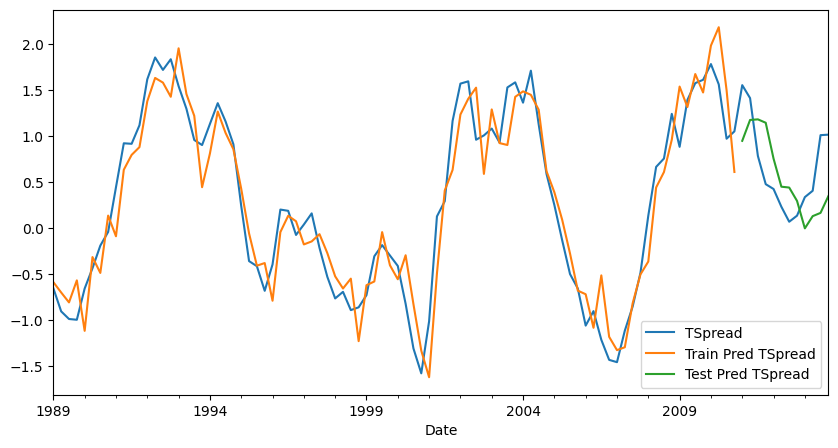

In [122]:
df1.loc[train_idx, 'Train Pred GDPGrowth'] = results.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test Pred GDPGrowth'] = fcast[:,0]
df1.iloc[-100:][plot_cols].plot(figsize=(10, 5))

<AxesSubplot: xlabel='Date'>

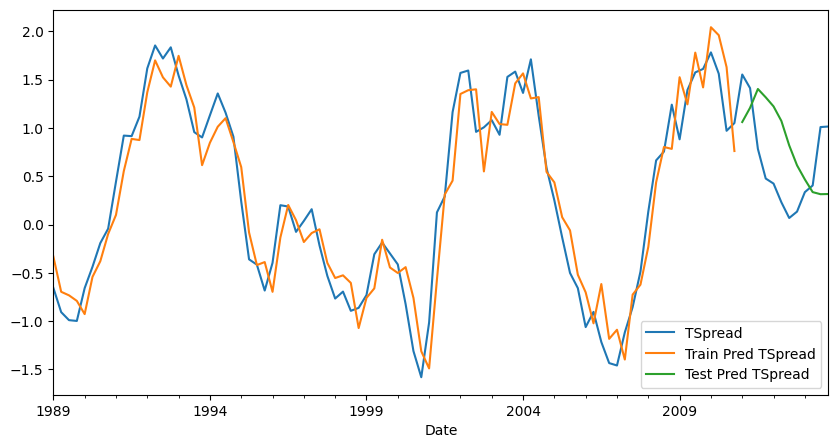

In [123]:
df1.loc[train_idx, 'Train Pred TSpread'] = results.fittedvalues['TSpread']
df1.loc[test_idx, 'Test Pred TSpread'] = fcast[:,1]
df1.iloc[-100:][plot_cols].plot(figsize=(10, 5))

ARIMA Baseline

In [124]:
for col in cols:
    model = ARIMA(train[col], order=(p, 0, q))
    res = model.fit()
    fcast = res.get_forecast(Ntest)
    y_train = df1.loc[train_idx, col]
    y_test = df1.loc[test_idx, col]
    print(f"{col} Train R^2: {r2_score(y_train, res.fittedvalues)}")
    print(f"{col} Test R^2: {r2_score(y_test, fcast.predicted_mean)}")

GDPGrowth Train R^2: 0.20569397090060804
GDPGrowth Test R^2: -0.8486457477319049
TSpread Train R^2: 0.8332486531709971
TSpread Test R^2: -2.9963834570680197
